In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification

## What is a Classifier?

## Binary Class Problem

In [2]:
# Load in log returns dataset
DATA = pd.read_csv('IWM_IFRA_IRBO.csv'); DATA = DATA.set_index('Date')

# converting IWM log returns into binary values 1's and 0's
DATA['IWM Direction'] = (DATA.IWM > 0).astype(int)
DATA.head()

,IFRA,IRBO,IWM,IWM Direction
Date,,,,
2023-07-05,-0.008439,-0.013893,-0.010015,0
2023-07-06,-0.012924,-0.015941,-0.016280,0
2023-07-07,0.003376,0.009840,0.010504,1
2023-07-10,0.006461,0.013072,0.016963,1
2023-07-11,0.008976,0.016475,0.010221,1


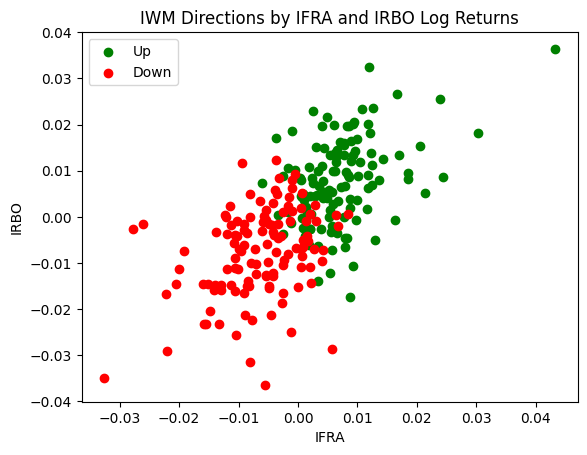

In [3]:
# Visualize IWM Direction by IFRA and IRBO Log Returns
plt.scatter(DATA.IFRA[DATA['IWM Direction'] == 1],
            DATA.IRBO[DATA['IWM Direction'] == 1],
           color='green',
           label='Up')
plt.scatter(DATA.IFRA[DATA['IWM Direction'] == 0],
            DATA.IRBO[DATA['IWM Direction'] == 0],
           color='red',
           label='Down')
plt.title('IWM Directions by IFRA and IRBO Log Returns')
plt.xlabel('IFRA')
plt.ylabel('IRBO')
plt.legend()
plt.show()

We can see that the data points are divided into red and green colors, green representing an upward direction in IWM and red represeneting a downward direction in IWM. One of the most popular problems in quantitative finance is to find a classifier (decision boundary) that most-accurately separates the data points that indicates an upward move from those that indicate a downward move. Through this model, we will be able to predict under the given IFRA and IRBO log return performance, which direction would IWM be expected to move in the next trading day. 

## Multi-class Problem

In [4]:
# categorizing IWM returns into 4 return classes
multiInterval = [DATA.IWM.min(), DATA.IWM.quantile(.25), 0, DATA.IWM.quantile(.75), DATA.IWM.max()]
multiLabels   = ['major loss','minor loss','minor gain','major gain']
DATA['IWM Return Type'] = pd.cut(DATA.IWM, bins = multiInterval, labels=multiLabels)

In [5]:
multiInterval

[-0.0420113475329548,
 -0.008269322797008,
 0,
 0.0086879424472927,
 0.0534603902829999]

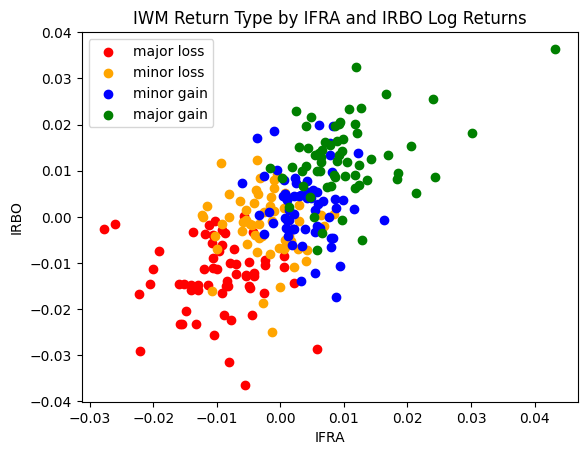

In [6]:
# Visualize IWM Return Type by IFRA and IRBO  Log Return
plt.scatter(DATA.IFRA[DATA['IWM Return Type'] == 'major loss'],
            DATA.IRBO[DATA['IWM Return Type'] == 'major loss'],
           color='red',
           label='major loss')
plt.scatter(DATA.IFRA[DATA['IWM Return Type'] == 'minor loss'],
            DATA.IRBO[DATA['IWM Return Type'] == 'minor loss'],
           color='orange',
           label='minor loss')
plt.scatter(DATA.IFRA[DATA['IWM Return Type'] == 'minor gain'],
            DATA.IRBO[DATA['IWM Return Type'] == 'minor gain'],
           color='blue',
           label='minor gain')
plt.scatter(DATA.IFRA[DATA['IWM Return Type'] == 'major gain'],
            DATA.IRBO[DATA['IWM Return Type'] == 'major gain'],
           color='green',
           label='major gain')

plt.title('IWM Return Type by IFRA and IRBO Log Returns')
plt.xlabel('IFRA')
plt.ylabel('IRBO')
plt.legend()
plt.show()

## Trading Factors Data

In [7]:
TF_DATA = pd.read_csv('trading_factors_data.csv') # read in .csv file
TF_DATA.head()

,sector,atr,macd,rsi,bb_mid,bb_upper,bb_lower,liquidity
0,Capital Goods,-1.257133,1.144681,64.788685,3.439315,3.480631,3.398000,Medium
1,Transportation,0.061118,0.379332,50.087518,3.666802,3.716298,3.617305,Medium
2,Consumer Services,-1.458222,0.089749,49.426936,4.302697,4.331839,4.273556,Low
3,Technology,0.156406,-1.911561,35.245458,4.175880,4.301052,4.050708,High
4,Health Care,-1.166682,0.255016,60.845875,3.747550,3.785450,3.709651,Medium


Since there are 31435 observations and 31435 of them are non-null values for each column. This means that there are no missing values for any of the variables.

In [8]:
TF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31435 entries, 0 to 31434
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sector     31435 non-null  object 
 1   atr        31435 non-null  float64
 2   macd       31435 non-null  float64
 3   rsi        31435 non-null  float64
 4   bb_mid     31435 non-null  float64
 5   bb_upper   31435 non-null  float64
 6   bb_lower   31435 non-null  float64
 7   liquidity  31435 non-null  object 
dtypes: float64(6), object(2)
memory usage: 1.9+ MB


In [9]:
features = ['atr', 'macd', 'rsi', 'bb_mid', 'bb_upper', 'bb_lower'] # numerical features only
response = 'liquidity'
TF_DATA.loc[:, features] = scale(TF_DATA.loc[:, features]) # standardizing indicators

In [10]:
TF_DATA.head()

,sector,atr,macd,rsi,bb_mid,bb_upper,bb_lower,liquidity
0,Capital Goods,-1.392712,1.079815,1.008666,-0.695295,-0.716651,-0.672630,Medium
1,Transportation,-0.084627,0.348207,-0.197922,-0.409229,-0.417685,-0.399921,Medium
2,Consumer Services,-1.592250,0.071391,-0.252138,0.390414,0.363185,0.416133,Low
3,Technology,0.009927,-1.841691,-1.416073,0.230941,0.324129,0.139020,High
4,Health Care,-1.302958,0.229371,0.685063,-0.307687,-0.329960,-0.285088,Medium


In [11]:
# Function to remove outlying values that lie > 3 standard deviations away from the mean
def remove_outliers(df, columns, n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean() # mean
        sd = df[col].std() # standard deviation
        
        df = df[(df[col] <= mean+(n_std*sd)) & (df[col] >= mean-(n_std*sd))] # criteria
        
    return df

In [12]:
TF_DATA1 = remove_outliers(TF_DATA, features, 3)
TF_DATA1.info()

Working on column: atr
Working on column: macd
Working on column: rsi
Working on column: bb_mid
Working on column: bb_upper
Working on column: bb_lower
<class 'pandas.core.frame.DataFrame'>
Index: 30189 entries, 0 to 31432
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sector     30189 non-null  object 
 1   atr        30189 non-null  float64
 2   macd       30189 non-null  float64
 3   rsi        30189 non-null  float64
 4   bb_mid     30189 non-null  float64
 5   bb_upper   30189 non-null  float64
 6   bb_lower   30189 non-null  float64
 7   liquidity  30189 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.1+ MB


Tne number of rows drops from 31435 to 30189 as 1246 potential outliers are removed.

In [13]:
# Declare an encoder that helps convert outcome strings to labels
le = LabelEncoder()
le.fit(TF_DATA1.loc[:, response])
TF_DATA1.liquidity = le.fit_transform(TF_DATA1.loc[:, response])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'High': 0, 'Low': 1, 'Medium': 2}

In [14]:
TF_DATA1.head()

,sector,atr,macd,rsi,bb_mid,bb_upper,bb_lower,liquidity
0,Capital Goods,-1.392712,1.079815,1.008666,-0.695295,-0.716651,-0.672630,2
1,Transportation,-0.084627,0.348207,-0.197922,-0.409229,-0.417685,-0.399921,2
2,Consumer Services,-1.592250,0.071391,-0.252138,0.390414,0.363185,0.416133,1
3,Technology,0.009927,-1.841691,-1.416073,0.230941,0.324129,0.139020,0
4,Health Care,-1.302958,0.229371,0.685063,-0.307687,-0.329960,-0.285088,2


In [15]:
X_train, X_test, y_train, y_test = train_test_split(TF_DATA1.loc[:, features], TF_DATA1.loc[:, response], test_size=0.2, random_state=0)

In [16]:
from sklearn.ensemble import RandomForestClassifier # importing the random forest module

rf_model = RandomForestClassifier(random_state=0) # define the random forest model

rf_model.fit(X_train[features], y_train) # fit the random forest model

importances = rf_model.feature_importances_ # get importance

indices = np.argsort(importances) # sort the features' index by their importance scores

Text(0.5, 0, 'Importance Score')

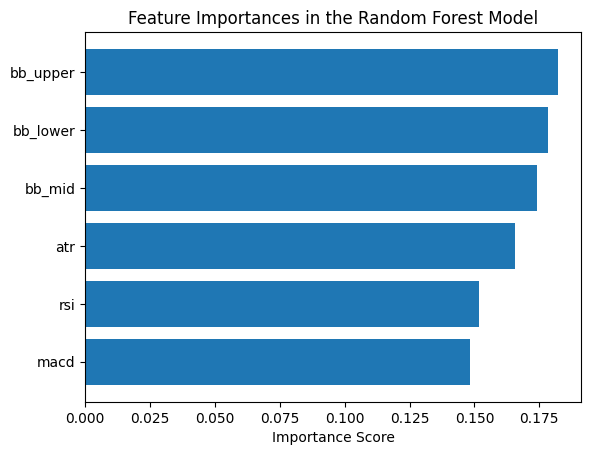

In [17]:
# Visualize and rank feature importance scores
plt.title('Feature Importances in the Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Score')

Since the importance scores for all features are >= 0.05, this implies that these features are significant in classifying market liquidity. Therefore, we DO NOT have to drop any of the features here.

Text(0.5, 1.0, 'Correlations Between Trading Factors')

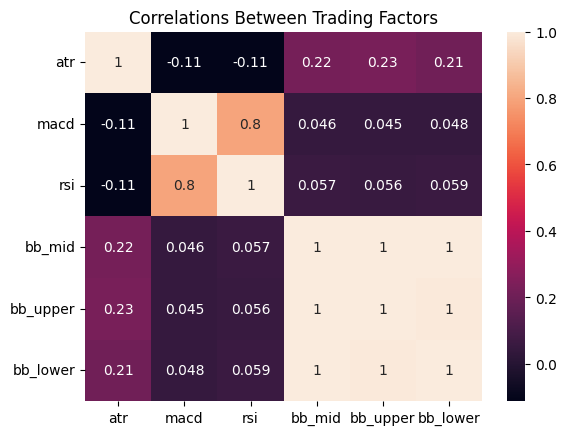

In [18]:
# plotting a correaltion heatmap to identify correlations b/w features
sns.heatmap(TF_DATA1.loc[:, features].corr(), annot=True)
plt.title("Correlations Between Trading Factors")

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF to identify high correlations b/w features
VIF = [variance_inflation_factor(TF_DATA1.loc[:, features].values, i) for i in range(len(features))]
VIF_table = pd.DataFrame({'Numerical Features': features, 'VIF': VIF})
VIF_table

/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Numerical Features,VIF
0,atr,1.145749
1,macd,2.781899
2,rsi,2.787220
3,bb_mid,inf
4,bb_upper,inf
5,bb_lower,inf


We find that bb_mid, bb_upper, and bb_lower have perfect positive correlation from the heatmap and have inf values for VIF, which means their movements are basically the same. This makes sense because bb_upper and bb_lower are factors that are derived by add and subtracting two standard deviations from bb_mid, and will therefore mimic the same movement, just not on the same scale.

To resolve this problem, we keep just the bb_mid feature and discard bb_upper and bb_lower. The result shows that high correlations (> 0.8) are removed from the heatmap and shows low VIF values for this set of features because they are all < 5. 

In [20]:
FEATURES_TO_DROP=['bb_upper', 'bb_lower'] # define features to frop
TF_DATA2 = TF_DATA1.drop(columns=FEATURES_TO_DROP) # drop feature in the original data set
X_train = X_train.drop(columns = FEATURES_TO_DROP) # drop feature in the training data set
X_test = X_test.drop(columns= FEATURES_TO_DROP) # drop feature in the testing data set
features = [f for f in features if f not in FEATURES_TO_DROP] # dropping bb_upper and bb_lower from our feature list

Text(0.5, 1.0, 'Correlations Between Trading Factors')

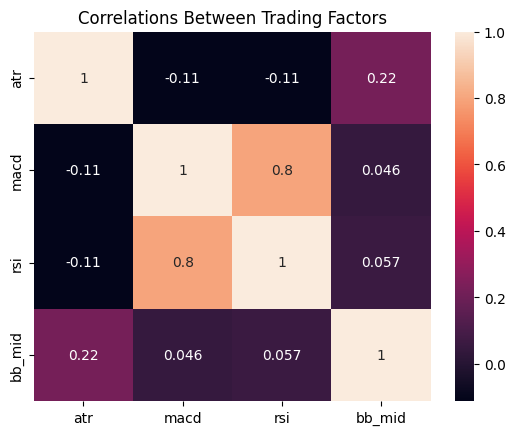

In [21]:
# plotting a correaltion heatmap to identify correlations b/w features
sns.heatmap(TF_DATA1.loc[:,features].corr(), annot=True)
plt.title("Correlations Between Trading Factors")

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF to identify high correlations b/w features
VIF = [variance_inflation_factor(TF_DATA1.loc[:, features].values, i) for i in range(len(features))]
VIF_table = pd.DataFrame({'Numerical Features': features, 'VIF': VIF})
VIF_table

,Numerical Features,VIF
0,atr,1.068984
1,macd,2.781333
2,rsi,2.786895
3,bb_mid,1.057301


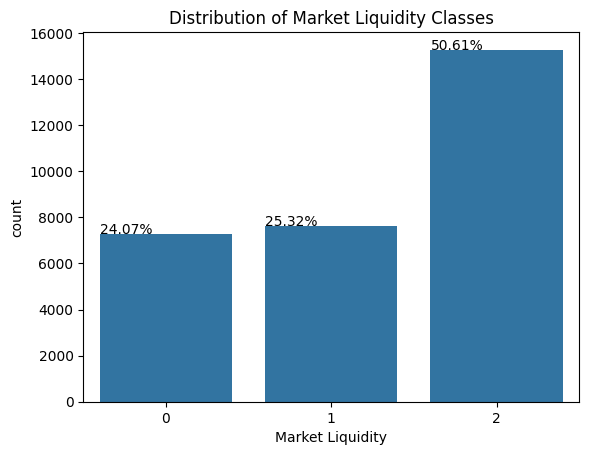

In [23]:
# Visualize boxplot to examine label distribution
ax = sns.countplot(x = "liquidity", data = TF_DATA1)
plt.title('Distribution of Market Liquidity Classes')
plt.xlabel('Market Liquidity')
total = len(TF_DATA2["liquidity"])
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x_coord = p.get_x() 
        y_coord = p.get_y() + p.get_height()+0.02
        ax.annotate(percentage, (x_coord, y_coord))

Although liquidity strengths are not perfectly balanced, in reality, it is reasonable to allow the majority bias of medium (class 2) liquidity since the market only experience high (class 0) and low liquidity (class 1) 2 to 3 hours out of the 8 hours of trading per day, on average.

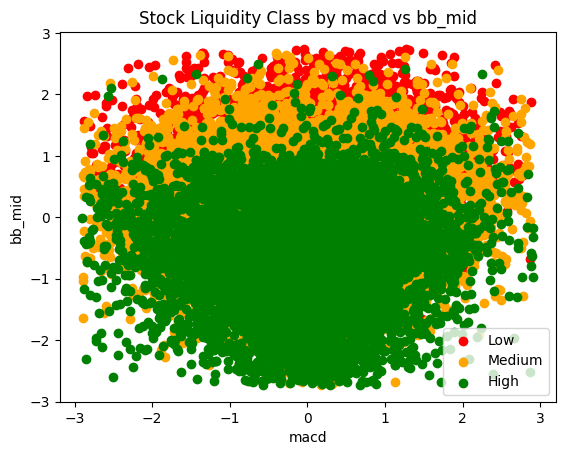

In [24]:
# Scatterplot to visualize the market liquidity classes by the indicators macd vs bb_mid

plt.scatter(TF_DATA1['macd'][TF_DATA1.liquidity == 1],
            TF_DATA1['bb_mid'][TF_DATA1.liquidity == 1],
           color='red',
           label='Low')
plt.scatter(TF_DATA1['macd'][TF_DATA1.liquidity == 2],
            TF_DATA1['bb_mid'][TF_DATA1.liquidity == 2],
           color='orange',
           label='Medium')
plt.scatter(TF_DATA1['macd'][TF_DATA1.liquidity == 0],
            TF_DATA1['bb_mid'][TF_DATA1.liquidity == 0],
           color='green',
           label='High')

plt.title('Stock Liquidity Class by macd vs bb_mid')
plt.xlabel('macd')
plt.ylabel('bb_mid')
plt.legend()
plt.show()

The macd_d and bb_mid values for high liquidity class overlap those for medium and low classes. This means that it is more difficult for a classifier to separate the 3 classes with low misclassification errors.

#### K-Nearest Neighbors (KNN)

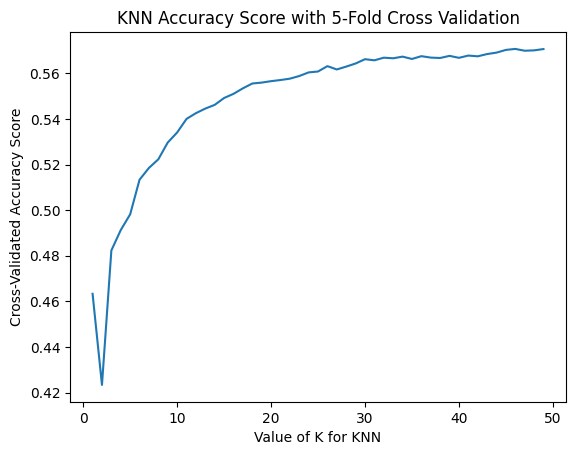

In [25]:
from sklearn.neighbors import KNeighborsClassifier
# Specifying the K of K-Fold CV
k_cv = 5
# choose k between 1 to 50
k_range = range(1, 50)
k_accuracy = []
# use iteration to caclulator different k in the KNN model, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, TF_DATA2.loc[:, features], TF_DATA2.loc[:, response], cv=k_cv, scoring='accuracy')
    k_accuracy.append(accuracy.mean())
    
plt.plot(k_range, k_accuracy)
plt.title('KNN Accuracy Score with '+str(k_cv)+'-Fold Cross Validation')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy Score')
plt.show()

In [26]:
# # build KNN model and choose n_neighbors
knn = KNeighborsClassifier(n_neighbors=20)
# train the model
knn.fit(X_train, y_train)
# predicted liquidity strengths 
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

In [27]:
train_error_knn= 1-knn.score(X_train,y_train)
test_error_knn= 1-knn.score(X_test,y_test)
print('KNN Training Error = %.3f' % train_error_knn)
print('KNN Testing Error = %.3f' % test_error_knn)

KNN Training Error = 0.391
KNN Testing Error = 0.445


In [28]:
train_accuracy_knn= knn.score(X_train,y_train)
test_accuracy_knn= knn.score(X_test,y_test)
print('KNN Training Accuracy Score = %.3f' % train_accuracy_knn)
print('KNN Testing Accuracy Score = %.3f' % test_accuracy_knn)

KNN Training Accuracy Score = 0.609
KNN Testing Accuracy Score = 0.555


Text(0.5, 1.0, 'KNN Confusion Matrix')

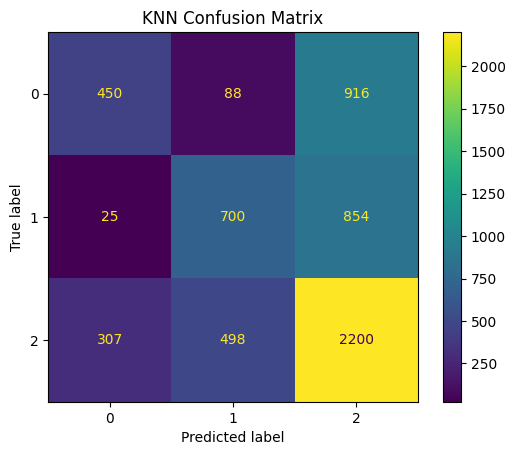

In [29]:
cm_knn = confusion_matrix(y_test, y_test_pred_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.title("KNN Confusion Matrix")

In [30]:
# printing full report
f1_score_knn= f1_score(y_test, y_test_pred_knn, average='weighted')
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.58      0.31      0.40      1454
           1       0.54      0.44      0.49      1579
           2       0.55      0.73      0.63      3005

    accuracy                           0.55      6038
   macro avg       0.56      0.49      0.51      6038
weighted avg       0.56      0.55      0.54      6038



In [31]:
# calculating probabilites
y_test_pred_knn_proba = knn.predict_proba(X_test)
auc_score_knn = roc_auc_score(y_test, y_test_pred_knn_proba, multi_class='ovr') #'ovr' b/c multi-class problem
print('KNN Classifier: ROC AUC=%.3f' % auc_score_knn)

KNN Classifier: ROC AUC=0.700


#### Support Vector Machines (SVM)

In [32]:
from sklearn import svm
# build SVC model and choose the Radial Basis Function (RBF) kernel function
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, probability=True).fit(X_train, y_train)
# choose the Polynomial kernel function
poly = svm.SVC(kernel='poly', degree=3, C=1, probability=True).fit(X_train, y_train)

# predicted liquidity strengths 
y_train_pred_rbf = rbf.predict(X_train)
y_test_pred_rbf = rbf.predict(X_test)
y_train_pred_poly = poly.predict(X_train)
y_test_pred_poly = poly.predict(X_test)

KeyboardInterrupt: 

In [ ]:
train_error_rbf= 1-rbf.score(X_train,y_train)
test_error_rbf= 1-rbf.score(X_test,y_test)
print('SVC (RBF Kernel) Training Error = %.3f' % train_error_rbf)
print('SVC (RBF Kernel) Testing Error = %.3f' % test_error_rbf)
train_error_poly= 1-poly.score(X_train,y_train)
test_error_poly= 1-poly.score(X_test,y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Error = %.3f' % train_error_poly)
print('SVC (3rd-Degree Polynomial Kernel) Testing Error = %.3f' % test_error_poly)

In [ ]:
train_accuracy_rbf= rbf.score(X_train,y_train)
test_accuracy_rbf= rbf.score(X_test,y_test)
print('SVC (RBF Kernel) Training Accuracy Score = %.3f' % train_accuracy_rbf)
print('SVC (RBF Kernel) Testing Accuracy Score = %.3f' % test_accuracy_rbf)
train_accuracy_poly= poly.score(X_train,y_train)
test_accuracy_poly= poly.score(X_test,y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Accuracy Score = %.3f' % train_accuracy_poly)
print('SVC (3rd-Degree Polynomial Kernel) Testing Accuracy Score = %.3f' % test_accuracy_poly)

In [ ]:
cm_rbf = confusion_matrix(y_test, y_test_pred_rbf, labels=rbf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=rbf.classes_)
disp.plot()
plt.title("SVC (RBF Kernel) Confusion Matrix")

In [ ]:
cm_poly = confusion_matrix(y_test, y_test_pred_poly, labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_poly, display_labels=poly.classes_)
disp.plot()
plt.title("SVC (3rd-Degree Polynomial Kernel) Confusion Matrix")

In [ ]:
# storing f1 score
f1_score_rbf= f1_score(y_test, y_test_pred_rbf, average='weighted')
print(classification_report(y_test, y_test_pred_rbf))

In [ ]:
# storing f1 score
f1_score_poly= f1_score(y_test, y_test_pred_poly, average='weighted')
print(classification_report(y_test, y_test_pred_poly))

In [ ]:
y_test_pred_rbf_proba = rbf.predict_proba(X_test)
auc_score_rbf = roc_auc_score(y_test, y_test_pred_rbf_proba, multi_class='ovr')
y_test_pred_poly_proba = poly.predict_proba(X_test)
auc_score_poly = roc_auc_score(y_test, y_test_pred_poly_proba, multi_class='ovr')
print('SVC (RBF Kernel) Classifier: ROC AUC=%.3f' % auc_score_rbf)
print('SVC (3rd-Degree Polynomial Kernel) Classifier: ROC AUC=%.3f' % auc_score_poly)

#### Decision (Classification) Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
# Fit the classifier with default hyper-parameters
nobs = 10
dt = DecisionTreeClassifier(random_state=0).fit(X_train.head(nobs),y_train[:nobs])
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names=FEATURES, class_names=['High','Low','Medium'], filled=True)

In [ ]:
# Fit the classifier with default hyper-parameters
#dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(dt, feature_names=FEATURES, class_names=['High','Low','Medium'], filled=True)

In [ ]:
def visualize_classifier(model, X_train, y_train, ax=None, cmap='rainbow', nobs = nobs):
    X = np.array(X_train.head(nobs)); y = np.array(y_train[:nobs])
    
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:,0], X[:,1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X[:,:2], y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.set_title("Tree Boundaries")

In [ ]:
# visualize tree splits
visualize_classifier(DecisionTreeClassifier(), X_train, y_train, 10)

In [ ]:
parameters = {'max_depth':range(3,20)}
dt = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
dt.fit(X_train, y_train)
tree_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_) 

In [ ]:
# fitting decision tree model
dt = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 8)
dt.fit(X_train, y_train)

# predicted liquidity strengths 
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

In [ ]:
train_error_dt= 1-dt.score(X_train,y_train)
test_error_dt= 1-dt.score(X_test,y_test)
print('Decision Tree Training Error = %.3f' % train_error_dt)
print('Decision Tree Testing Error = %.3f' % test_error_dt)

In [ ]:
train_accuracy_dt= dt.score(X_train,y_train)
test_accuracy_dt= dt.score(X_test,y_test)
print('Decision Tree Training Accuracy Score = %.3f' % train_accuracy_dt)
print('Decision Tree Testing Accuracy Score = %.3f' % test_accuracy_dt)

In [ ]:
cm_dt = confusion_matrix(y_test, y_test_pred_dt, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp.plot()
plt.title("Decision Tree Confusion Matrix")

In [ ]:
# storing f1 score
f1_score_dt= f1_score(y_test, y_test_pred_dt, average='weighted')
print(classification_report(y_test, y_test_pred_dt))

In [ ]:
y_test_pred_dt_proba = dt.predict_proba(X_test)
auc_score_dt = roc_auc_score(y_test, y_test_pred_dt_proba, multi_class='ovr')
print('Decision Tree Classifier: ROC AUC=%.3f' % auc_score_dt)

#### Ensemble Method: Bagging

In [ ]:
# Create the parameter grid based on the results of random search 
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 1000],
    'max_samples':[1, 5, 10],
    'max_features': [1, 2 , 3 , 4]
}
# Create a based model
bagging = BaggingClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = bagging, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
# Creating a Bagging classifier
bagging = BaggingClassifier(max_features= 4, max_samples= 10, n_estimators= 25)
# fit the bagging on the training data
bagging.fit(X_train, y_train)

# predicted liquidity strengths 
y_train_pred_bagging = bagging.predict(X_train)
y_test_pred_bagging = bagging.predict(X_test)

In [ ]:
train_error_bagging= 1-bagging.score(X_train,y_train)
test_error_bagging= 1-bagging.score(X_test,y_test)
print('Bagging Training Error = %.3f' % train_error_bagging)
print('Bagging Testing Error = %.3f' % test_error_bagging)

In [ ]:
train_accuracy_bagging= bagging.score(X_train,y_train)
test_accuracy_bagging= bagging.score(X_test,y_test)
print('Bagging Training Accuracy Score = %.3f' % train_accuracy_bagging)
print('Bagging Testing Accuracy Score = %.3f' % test_accuracy_bagging)

In [ ]:
cm_bagging = confusion_matrix(y_test, y_test_pred_bagging, labels=bagging.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagging, display_labels=bagging.classes_)
disp.plot()
plt.title("Bagging Confusion Matrix")

In [ ]:
# storing f1 score
f1_score_bagging= f1_score(y_test, y_test_pred_bagging, average='weighted')
print(classification_report(y_test, y_test_pred_bagging))

In [ ]:
y_test_pred_bagging_proba = bagging.predict_proba(X_test)
auc_score_bagging = roc_auc_score(y_test, y_test_pred_bagging_proba, multi_class='ovr')
print('Bagging Method: ROC AUC=%.3f' % auc_score_bagging)

#### Ensemble Method: Random Forest

In [ ]:
# Create the parameter grid based on the results of random search 
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=  12.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time= 1.1min


/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=  12.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=  12.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_

In [36]:
#Create a Random Forest Classifier
rf = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 3, min_samples_leaf= 4, min_samples_split= 12, n_estimators= 300)
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

# predicted liquidity strengths 
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [37]:
train_error_rf= 1-rf.score(X_train,y_train)
test_error_rf= 1-rf.score(X_test,y_test)
print('Random Forest Training Error = %.3f' % train_error_rf)
print('Random Forest Testing Error = %.3f' % test_error_rf)

Random Forest Training Error = 0.166
Random Forest Testing Error = 0.440


In [38]:
train_accuracy_rf= rf.score(X_train,y_train)
test_accuracy_rf= rf.score(X_test,y_test)
print('Random Forest Training Accuracy Score = %.3f' % train_accuracy_rf)
print('Random Forest Testing Accuracy Score = %.3f' % test_accuracy_rf)

Random Forest Training Accuracy Score = 0.834
Random Forest Testing Accuracy Score = 0.560


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

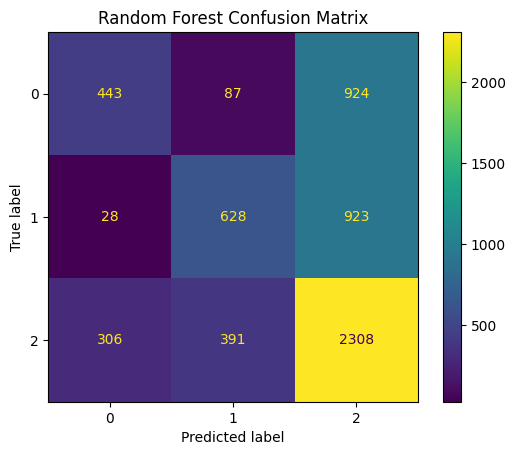

In [39]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot()
plt.title("Random Forest Confusion Matrix")

In [40]:
# storing f1 score
f1_score_rf= f1_score(y_test, y_test_pred_rf, average='weighted')
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.57      0.30      0.40      1454
           1       0.57      0.40      0.47      1579
           2       0.56      0.77      0.64      3005

    accuracy                           0.56      6038
   macro avg       0.56      0.49      0.50      6038
weighted avg       0.56      0.56      0.54      6038



In [42]:
y_test_pred_rf_proba = rf.predict_proba(X_test)

auc_score_rf = roc_auc_score(y_test, y_test_pred_rf_proba, multi_class='ovr')
print('Random Forest Method: ROC AUC=%.3f' % auc_score_rf)
y_test_pred_rf_proba

Random Forest Method: ROC AUC=0.712


array([[0.10891656, 0.19753747, 0.69354597],
       [0.09294122, 0.5201597 , 0.38689908],
       [0.45936546, 0.02701244, 0.5136221 ],
       ...,
       [0.00953174, 0.79986868, 0.19059957],
       [0.64809121, 0.0043901 , 0.34751869],
       [0.09968306, 0.26982562, 0.63049133]])

#### Ensemble Method: Boosting (AdaBoost)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 100, 200, 300, 1000],
    'learning_rate':[1, 5, 10]
}
# Create a based model
boosting = AdaBoostClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
#Create a Boosting Classifier
boosting = AdaBoostClassifier(learning_rate= 1, n_estimators= 50)
#Train the model using the training sets y_pred=clf.predict(X_test)
boosting.fit(X_train,y_train)

# predicted liquidity strengths 
y_train_pred_boosting = boosting.predict(X_train)
y_test_pred_boosting = boosting.predict(X_test)

In [ ]:
train_error_boosting= 1-boosting.score(X_train,y_train)
test_error_boosting= 1-boosting.score(X_test,y_test)
print('AdaBoost Training Error = %.3f' % train_error_boosting)
print('AdaBoost Testing Error = %.3f' % test_error_boosting)

In [ ]:
train_accuracy_boosting= boosting.score(X_train,y_train)
test_accuracy_boosting= boosting.score(X_test,y_test)
print('AdaBoost Training Accuracy Score = %.3f' % train_accuracy_boosting)
print('AdaBoost Testing Accuracy Score = %.3f' % test_accuracy_boosting)

Text(0.5, 1.0, 'AdaBoost Confusion Matrix')

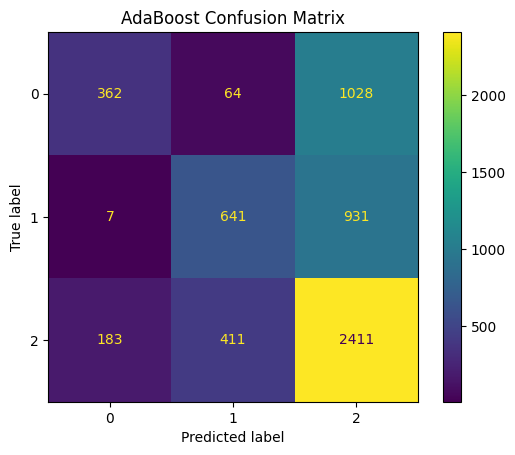

In [75]:
cm_boosting = confusion_matrix(y_test, y_test_pred_boosting, labels=boosting.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_boosting, display_labels=boosting.classes_)
disp.plot()
plt.title("AdaBoost Confusion Matrix")

In [76]:
# storing f1 score
f1_score_boosting= f1_score(y_test, y_test_pred_boosting, average='weighted')
print(classification_report(y_test, y_test_pred_boosting))

              precision    recall  f1-score   support

           0       0.66      0.25      0.36      1454
           1       0.57      0.41      0.48      1579
           2       0.55      0.80      0.65      3005

    accuracy                           0.57      6038
   macro avg       0.59      0.49      0.50      6038
weighted avg       0.58      0.57      0.54      6038



In [77]:
y_test_pred_boosting_proba = boosting.predict_proba(X_test)
auc_score_boosting = roc_auc_score(y_test, y_test_pred_boosting_proba, multi_class='ovr')
print('Boosting (AdaBoost) Method: ROC AUC=%.3f' % auc_score_boosting)

Boosting (AdaBoost) Method: ROC AUC=0.693


### Summarizing Model Results

In [78]:
df = pd.DataFrame(data={
         'Model':['KNN', 'SVC-RBF', 'SVC-Polynomial(3rd-degree)', 'Decision Tree', 'Bagging','Random Forest', 'Boosting']
         ,'Train Error':[train_error_knn, train_error_rbf, train_error_poly, train_error_dt, train_error_bagging, train_error_rf, train_error_boosting]
         ,'Test Error':[test_error_knn, test_error_rbf, test_error_poly, test_error_dt, test_error_bagging, test_error_rf, test_error_boosting] 
         ,'Train Accuracy':[train_accuracy_knn, train_accuracy_rbf, train_accuracy_poly, train_accuracy_dt, train_accuracy_bagging, train_accuracy_rf, train_accuracy_boosting]
         ,'Test Accuracy':[test_accuracy_knn, test_accuracy_rbf, test_accuracy_poly, test_accuracy_dt, test_accuracy_bagging, test_accuracy_rf, test_accuracy_boosting]
         ,'F1 Score':[f1_score_knn, f1_score_rbf, f1_score_poly, f1_score_dt, f1_score_bagging, f1_score_rf, f1_score_boosting]
         ,'AUC Score':[auc_score_knn, auc_score_rbf, auc_score_poly, auc_score_dt, auc_score_bagging, auc_score_rf, auc_score_boosting]})
df

,Model,Train Error,Test Error,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,KNN,0.391454,0.445181,0.608546,0.554819,0.538665,0.700214
1,SVC-RBF,0.417498,0.429447,0.582502,0.570553,0.524540,0.726588
2,SVC-Polynomial(3rd-degree),0.441348,0.449487,0.558652,0.550513,0.467113,0.714245
3,Decision Tree,0.398369,0.439715,0.601631,0.560285,0.534082,0.705020
4,Bagging,0.469546,0.484101,0.530454,0.515899,0.442437,0.655834
5,Random Forest,0.166039,0.439881,0.833961,0.560119,0.539827,0.711850
6,Boosting,0.418244,0.434581,0.581756,0.565419,0.536710,0.692698


### Liquidity Strength Prediction

Random Forest seems to be the best model because it has the the lowest test error, highest test accuracy, highest F1 score, and highest AUC score.

We predict the liquidity strengths in the next 14 trading days (2 trading weeks), and find that the market liquidity strengths are classified as medium (class 2) in 12 out of 14 days.

Therefore, as a trader, I would not expect large market fluctuations (caused by high liquidity), nor market stagnation (caused by low liquidity) in the next two weeks.

In [79]:
y_test_pred_rf[:14]

array([2, 1, 0, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1])